In [ ]:
__nbid__ = '00XX'
__author__ = 'Brian Merino <brian.merino@noirlab.edu>, Vinicius Placco <vinicius.placco@noirlab.edu>'
__version__ = '20240606' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['flamingos-2','gemini','browndwarf','dwarf','dragons']

# Gemini GHOST XX Oph reduction using DRAGONS Python API
***
## Public archival data from ghost_tutorial - GS-ENG-GHOST-COM-3-915 (XX Oph)
#### adapted from https://dragons.readthedocs.io/projects/ghost-drtutorial/en/release-3.2.x/index.html
***

# Note: This notebook may take more than an hour to run. 

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [About the dataset](#About)
* [Downloading data for reduction](#Downloading_Data)
* [Set up the DRAGONS logger](#DRAGONS_logger)
* [Create list update and reduce functions](#func)
* [Reduce biases](#Reduce_biases)
* [Create File Lists](#File_Lists)
* [Create Master Dark](#Master_dark)
* [Create Bad Pixel Mask](#BPM)
* [Create Master Flat Field](#Master_Flat)
* [Reduce Science Images](#Reduce_Science)
* [Display stacked final image](#Display_Image)
* [Clean-up (optional)](#Clean-up)

<a class="anchor" id="goals"></a>
# Goals
Showcase how to reduce GHOST spectroscopy data using the Gemini DRAGONS package on the Data Lab science platform using a custom DRAGONS kernel `"DRAGONS (Py3.7)"`. The steps include downloading data from the Gemini archive, setting up the DRAGONS calibration service, processing biases, flats, and arcs, creating master flats and slit-flats, reducing the standards and science data, and finally creating the final reduced spectra for GHOST's red and blue arms. 



<a class="anchor" id="summary"></a>
# Summary
DRAGONS is a Python-based astronomical data reduction platform written by the Gemini Science User Support Department. It can currently be used to reduce imaging data from Gemini instruments GMOS, NIRI, Flamingos 2, GSAOI, and GNIRS, as well as spectroscopic data taken with GHOST and GMOS in longslit mode. Linked <a href="https://dragons.readthedocs.io/en/v3.2.1/">here</a> is a general list of guides, manuals, and tutorials about the use of DRAGONS.

The DRAGONS kernel has been made available in the Data Lab environment, allowing users to access the routines without being dependent on installing the software on their local machines. 

In this notebook, we present an example of a DRAGONS Jupyter notebook that works in the Data Lab environment to reduce Gemini South GHOST blue:2x2 and red:2x2 spectroscopy data fully. This notebook will not present all of the details of the many options available to adjust or optimize the DRAGONS GHOST data reduction process; rather, it will just show one example of a standard reduction of a GHOST spectroscopic dataset. 

The data used in this notebook example is GHOST blue:2x2 and red:2x2 spectroscopy data from the Gemini archive of the star XX Oph from the GHOST commisioning run, program ID <a href="https://archive.gemini.edu/programinfo/GS-CAL20230416">GS-CAL20230416</a>.

<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

For this notebook specifically, please acknowledge:
* DRAGONS publication: Labrie et al., <a href="https://ui.adsabs.harvard.edu/abs/2019ASPC..523..321L/abstract">"DRAGONS - Data Reduction for Astronomy from Gemini Observatory North and South"</a>, ASPC, 523, 321L 

* <a href="https://zenodo.org/record/7776065#.ZDg5qOzMLUI">DRAGONS open source software publication</a>

<a class="anchor" id="imports"></a>
# Importing Python libraries

In [1]:
import warnings
import glob
import os
import numpy as np
import astrodata

from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import gemini_instruments
from gempy.utils import logutils
from gempy.adlibrary import dataselect
from gempy.adlibrary import plotting

from recipe_system import cal_service
from recipe_system.reduction.coreReduce import Reduce

warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings("ignore")

<a class="anchor" id="About"></a>
# About the dataset

The GHOST data used for this tutorial is of the star XX Oph. IFU-1 was used to obtain standard resolution of the star. The data was obtained during the commissioning run.

The table below contains a summary of the dataset:

| Observation Type | File name(s) | Purpose and Exposure (seconds) |
| :--- | :--- | :---: |
| Science | S20230416S0079 | blue:2x2, slow; red:2x2, medium |
| Science bias | S20230417S0011-015 |  |
| Science flats | S20230416S0047 | 1x1; blue:slow; red:medium |
| Science Arcs | S20230416S0049-51 | 1x1; blue:slow; red:medium |
| Flat biases <br> Arc Biases | S20230417S0036-40 | 1x1; blue:slow; red:medium |
| Standard (CD -32 9927) | S20230416S0073 | blue:2x2, slow; red:2x2, medium |
| Standard biases <br> Standard flats <br> Standard arc <br> Standard flat biases <br> Standard arc biases | In this case, the calibrations for the science can be used for the standard star. |  |
| BPMs | bpm_20220601_ghost_blue_11_full_4amp.fits <br> bpm_20220601_ghost_red_11_full_4amp.fits |  |

<a class="anchor" id="Downloading_Data"></a>
# Downloading the data

Download the spectroscopic and calibration data from the Gemini archive to the current working directory. This step only needs to be executed once.

If you run this notebook for the first time and need to download the dataset, set the variable "download=True". The notebook will not redownload the dataset if it is set to False. This will become particularly useful if you run the notebooks more than once. 

In [ ]:
%%bash 

# create file that lists FITS files to be downloaded
echo "\
https://archive.gemini.edu/file/S20230416S0047.fits
https://archive.gemini.edu/file/S20230416S0049.fits
https://archive.gemini.edu/file/S20230416S0050.fits
https://archive.gemini.edu/file/S20230416S0051.fits
https://archive.gemini.edu/file/S20230416S0073.fits
https://archive.gemini.edu/file/S20230416S0079.fits
https://archive.gemini.edu/file/S20230417S0011.fits
https://archive.gemini.edu/file/S20230417S0012.fits
https://archive.gemini.edu/file/S20230417S0013.fits
https://archive.gemini.edu/file/S20230417S0014.fits
https://archive.gemini.edu/file/S20230417S0015.fits
https://archive.gemini.edu/file/S20230417S0036.fits
https://archive.gemini.edu/file/S20230417S0037.fits
https://archive.gemini.edu/file/S20230417S0038.fits
https://archive.gemini.edu/file/S20230417S0039.fits
https://archive.gemini.edu/file/S20230417S0040.fits
https://archive.gemini.edu/file/bpm_20220601_ghost_blue_11_full_4amp.fits
https://archive.gemini.edu/file/bpm_20220601_ghost_red_11_full_4amp.fits\
" > ghost.list

In [ ]:
%%bash

download="True"

if [ $download == "True" ]; then
    wget --no-check-certificate -N -q -i ghost.list

else
    echo "Skipping download. To download the data set used in this notebook, set download=True."
fi

### This tutorial will create a large number of intermediate files that will temporarily stored in the working directory. To make sure none of the original data is lost, we are going to create a directory called raw to safely store the priliminary data.

In [ ]:
os.mkdir('raw')

# Move the raw files in new directory called raw

In [ ]:
%%bash 

mv *fits raw/

<a class="anchor" id="File_Lists"></a>
# Create file lists

This data set contains science and calibration frames. For some programs, it could have different observed targets and exposure times depending on how you organize your raw data.

The DRAGONS data reduction pipeline does not organize the data for you. You have to do it. DRAGONS provides tools to help you with that.

The first step is to create lists that will be used in the data reduction process. For that, we use dataselect. Please refer to the [dataselect](https://dragons.readthedocs.io/projects/recipe-system-users-manual/en/stable/supptools/dataselect.html?highlight=dataselect) documentation for details regarding its usage.

In [2]:
all_files = glob.glob('raw/S2023*.fits')
all_files.append(glob.glob('raw/bpm*.fits')[0])
all_files.append(glob.glob('raw/bpm*.fits')[1])
all_files.sort()

<a class="anchor" id="DRAGONS_logger"></a>
# Setting up the DRAGONS logger

DRAGONS comes with a local calibration manager that uses the same calibration association rules as the Gemini Observatory Archive. This allows reduce to make requests to a local light-weight database for matching processed calibrations when needed to reduce a dataset.

This tells the system where to put the calibration database. This database will keep track of the processed calibrations we will send to it.

In [3]:
logutils.config(file_name='ghost.log')
caldb = cal_service.set_local_database()
caldb.init("w")

# Add the Bad Pixel Masks to the calibration database

# GP13

In [4]:
import recipe_system
recipe_system.__version__

'3.2.1'

In [5]:
ad = astrodata.open('raw/S20230417S0012.fits')

In [6]:
ad.tags

{'BIAS', 'BUNDLE', 'CAL', 'GEMINI', 'GHOST', 'RAW', 'SOUTH', 'UNPREPARED'}

In [7]:
caldb.add_cal(glob.glob('raw/bpm*.fits')[0])
caldb.add_cal(glob.glob('raw/bpm*.fits')[1])

# Use dataselect to choose the all the BIAS files.

In [8]:
biasbundles = dataselect.select_data(all_files, ['BIAS'], [])
print(biasbundles)

['raw/S20230417S0011.fits', 'raw/S20230417S0012.fits', 'raw/S20230417S0013.fits', 'raw/S20230417S0014.fits', 'raw/S20230417S0015.fits', 'raw/S20230417S0036.fits', 'raw/S20230417S0037.fits', 'raw/S20230417S0038.fits', 'raw/S20230417S0039.fits', 'raw/S20230417S0040.fits']


<a class="anchor" id="func"></a>
# update_list and reduce_func

This notebook will require updating the list of files in your working directory and calling the reduce command several times. To reduce the repetitive text, we have created two functions that will cut down the number of lines included in this notebook. 

In [9]:
def update_list():
    #Create a new file list that contains the intermediate files
    #identify all of the files in the working directory
    intermediate = os.listdir()
    new_all_files = []

    #Since os.listdir() returns all files in the working directory
    #this loop will pick out only the fits files and add them to a list.
    for i in intermediate:
        if i[-5:] == '.fits':
            new_all_files.append(i)
    #print(new_all_files)
    print('%i files in the list.'%len(new_all_files))

    return new_all_files

In [10]:
def reduce_func(files_list,uparms=None,recipename=None):
    reduce = Reduce()
    reduce.files.extend(files_list)

    if uparms != None:
        #reduce_stdred.uparms = [('scaleCountsToReference:tolerance', 1)]
        reduce.uparms = [uparms]
    
    if recipename!= None:
        #reduce_stdred.recipename = 'reduceStandard'
        reduce.recipename = recipename
    
    reduce.runr()

<a class="anchor" id="Reduce_biases"></a>
# Use reduce_func() to reduce the biases

All submitted files appear valid:
raw/S20230417S0011.fits ... raw/S20230417S0040.fits, 10 files submitted.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
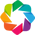

RECIPE: processBundle
   PRIMITIVE: splitBundle
   ----------------------
   Unbundling S20230417S0011.fits
   Unbundling S20230417S0012.fits
   Unbundling S20230417S0013.fits
   Unbundling S20230417S0014.fits
   Unbundling S20230417S0015.fits
   Unbundling S20230417S0036.fits
   Unbundling S20230417S0037.fits
   Unbundling S20230417S0038.fits
   Unbundling S20230417S0039.fits
   Unbundling S20230417S0040.fits
   .
	Wrote S20230417S0011_slit.fits in output directory
	Wrote S20230417S0011_blue001.fits in output directory
	Wrote S20230417S0011_red001.fits in output directory
	Wrote S20230417S0012_slit.fits in output directory
	Wrote S20230417S0012_blue001.fits in output directory
	Wrote S20230417S0012_red001.fits in output directory
	Wrote S20230417S0013_slit.fits in output directory
	Wrote S20230417S0013_blue001.fits in output directory
	Wrote S20230417S0013_red001.fits in output directory
	Wrote S20230417S0014_slit.fits in output directory
	Wrote S20230417S0014_blue001.fits in output d

In [11]:
reduce_func(biasbundles)

# DRAGONS' reduce() function creates a lot of intermediate files that are stored in the working directory. Before calling it again, we first need to udpate our list of files using update_list().

In [12]:
new_all_files = update_list()

30 files in the list.


# Now use dataselect to choose the slit biases.

In [13]:
biasslit = dataselect.select_data(new_all_files, ['BIAS','SLIT'])
print(biasslit)

['S20230417S0040_slit.fits', 'S20230417S0011_slit.fits', 'S20230417S0012_slit.fits', 'S20230417S0013_slit.fits', 'S20230417S0014_slit.fits', 'S20230417S0015_slit.fits', 'S20230417S0036_slit.fits', 'S20230417S0037_slit.fits', 'S20230417S0038_slit.fits', 'S20230417S0039_slit.fits']


<a class="anchor" id="Reduce_slit_biases"></a>
# Reduce the slit biases.

In [14]:
reduce_func(biasslit)

All submitted files appear valid:
S20230417S0040_slit.fits ... S20230417S0039_slit.fits, 10 files submitted.
RECIPE: makeProcessedSlitBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini da

# Once again, update the list of files.

In [15]:
new_all_files2 = update_list()

31 files in the list.


# Use dataselect to choose the red science biases.

In [16]:
expression = "binning==\'2x2\'"
parsed_expr = dataselect.expr_parser(expression)
biasredsci = dataselect.select_data(new_all_files2, ['BIAS', 'RED'], [], parsed_expr)

<a class="anchor" id="Reduce_red_science_biases"></a>
# Reduce the red science biases.

In [17]:
reduce_func(biasredsci)

All submitted files appear valid:
S20230417S0011_red001.fits ... S20230417S0015_red001.fits, 5 files submitted.
RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      ------------------

<a class="anchor" id="blue_science_biases"></a>
# Select the blue science biases and reduce them.

In [18]:
expression = 'binning==\'2x2\''
parsed_expr = dataselect.expr_parser(expression)
biasbluesci = dataselect.select_data(new_all_files2, ['BIAS','BLUE'], [], parsed_expr)

In [19]:
reduce_func(biasbluesci)

All submitted files appear valid:
S20230417S0011_blue001.fits ... S20230417S0015_blue001.fits, 5 files submitted.
RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      ----------------

<a class="anchor" id="red_flat_arc_biases"></a>
# Select the red flat/arc biases and reduce them. 

In [20]:
expression = 'binning==\'1x1\''
parsed_expr = dataselect.expr_parser(expression)
biasredflatarc = dataselect.select_data(new_all_files2, ['BIAS','RED'], [], parsed_expr)

In [21]:
reduce_func(biasredflatarc)

All submitted files appear valid:
S20230417S0036_red001.fits ... S20230417S0040_red001.fits, 5 files submitted.
RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      ------------------

<a class="anchor" id="blue_flat_arc_biases"></a>
# Select the blue flat/arc biases and reduce them. 

In [22]:
expression = 'binning==\'1x1\''
parsed_expr = dataselect.expr_parser(expression)
biasblueflatarc = dataselect.select_data(new_all_files2, ['BIAS','BLUE'], [], parsed_expr)

In [23]:
reduce_func(biasblueflatarc)

All submitted files appear valid:
S20230417S0040_blue001.fits ... S20230417S0039_blue001.fits, 5 files submitted.
RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      ----------------

# Clean-up
### GHOST reduction creates a lot of, often big, files in the work directory. It is recommended to clean up between each reduction phase. If you want to save the intermediate files, move them (mv) somewhere else. In this tutorial, we will simply delete them.

In [24]:
%%bash

rm *fits

# Master Flats and Slit-flats
### Debundle the flats then reduce them.

In [25]:
flatbundles = dataselect.select_data(all_files, ['FLAT'], [])

In [26]:
reduce_func(flatbundles)

All submitted files appear valid:
raw/S20230416S0047.fits
RECIPE: processBundle
   PRIMITIVE: splitBundle
   ----------------------
   Unbundling S20230416S0047.fits
   .
	Wrote S20230416S0047_slit.fits in output directory
	Wrote S20230416S0047_blue001.fits in output directory
	Wrote S20230416S0047_blue002.fits in output directory
	Wrote S20230416S0047_blue003.fits in output directory
	Wrote S20230416S0047_blue004.fits in output directory
	Wrote S20230416S0047_blue005.fits in output directory
	Wrote S20230416S0047_red001.fits in output directory
	Wrote S20230416S0047_red002.fits in output directory
	Wrote S20230416S0047_red003.fits in output directory
	Wrote S20230416S0047_red004.fits in output directory
	Wrote S20230416S0047_red005.fits in output directory

reduce completed successfully.


# Update the list of files.

In [27]:
new_all_files3 = update_list()

11 files in the list.


# Select the Slit-flats and reduce them. 

In [28]:
slitflat = dataselect.select_data(new_all_files3, ['SLITFLAT'], [])

In [29]:
reduce_func(slitflat)

All submitted files appear valid:
S20230416S0047_slit.fits
RECIPE: makeProcessedSlitFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
      PRIMITIVE: addDQ
      ----------------
      No BPMs found for S20230416S0047_slit_prepared.fits and none supplied by the user.
      
      .
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of t

# Select and reduce the red flats.

In [30]:
flatred = dataselect.select_data(new_all_files3, ['FLAT','RED'], [])

In [31]:
reduce_func(flatred)

All submitted files appear valid:
S20230416S0047_red001.fits ... S20230416S0047_red005.fits, 5 files submitted.
RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      ------------------

Fitting (this can sometimes take a while...)
Time after 1 iteration(s): 0:00:17.517335
Time after 2 iteration(s): 0:00:55.642430
Time after 3 iteration(s): 0:01:21.383086


   .
   PRIMITIVE: removeScatteredLight
   -------------------------------
   Not removing scattered light since skip=True
   .


Time after 4 iteration(s): 0:01:39.018849
RMS 2.925072644566168 -> 0.03208887103656709
MAX 19.3780725597353 -> 0.09416747350633159


   PRIMITIVE: measureBlaze
   -----------------------
   S20230416S0047_red001_fibersTraced.fits: using slit profile from the processed_slitflat S20230416S0047_slit_slitflat.fits (obtained from ~/.dragons/cal_manager.db)


    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   .
   PRIMITIVE: storeProcessedFlat
   -----------------------------
      PRIMITIVE: storeCalibration
      ---------------------------


      ~/.dragons/cal_manager.db: Storing calibrations/processed_flat/S20230416S0047_red001_flat.fits as processed_flat
      .
   .
	Wrote S20230416S0047_red001_flat.fits in output directory

reduce completed successfully.


# Select and reduce the blue flats.

In [32]:
flatblue = dataselect.select_data(new_all_files3, ['FLAT','BLUE'], [])

In [33]:
reduce_func(flatblue)

All submitted files appear valid:
S20230416S0047_blue001.fits ... S20230416S0047_blue005.fits, 5 files submitted.
RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      ----------------

Fitting (this can sometimes take a while...)
Time after 1 iteration(s): 0:00:07.882252
Time after 2 iteration(s): 0:00:12.176983
Time after 3 iteration(s): 0:00:16.613921
Time after 4 iteration(s): 0:00:24.635518


   .
   PRIMITIVE: removeScatteredLight
   -------------------------------
   Not removing scattered light since skip=True
   .


Time after 5 iteration(s): 0:00:30.968594
RMS 3.423923221856902 -> 0.04432204427323705
MAX 20.384716534993 -> 0.1502659677723841


   PRIMITIVE: measureBlaze
   -----------------------
   S20230416S0047_blue001_fibersTraced.fits: using slit profile from the processed_slitflat S20230416S0047_slit_slitflat.fits (obtained from ~/.dragons/cal_manager.db)


    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...

   .
   PRIMITIVE: storeProcessedFlat
   -----------------------------
      PRIMITIVE: storeCalibration
      ---------------------------


      ~/.dragons/cal_manager.db: Storing calibrations/processed_flat/S20230416S0047_blue001_flat.fits as processed_flat
      .
   .
	Wrote S20230416S0047_blue001_flat.fits in output directory

reduce completed successfully.


# Clean-up

In [34]:
%%bash

rm *fits

# Arcs
### Debundle the arcs and reduce them.

In [35]:
arcbundles = dataselect.select_data(all_files, ['ARC'], [])

In [36]:
reduce_func(arcbundles)

All submitted files appear valid:
raw/S20230416S0049.fits ... raw/S20230416S0051.fits, 3 files submitted.
RECIPE: processBundle
   PRIMITIVE: splitBundle
   ----------------------
   Unbundling S20230416S0049.fits
   Unbundling S20230416S0050.fits
   Unbundling S20230416S0051.fits
   .
	Wrote S20230416S0049_slit.fits in output directory
	Wrote S20230416S0049_blue001.fits in output directory
	Wrote S20230416S0049_red001.fits in output directory
	Wrote S20230416S0050_slit.fits in output directory
	Wrote S20230416S0050_blue001.fits in output directory
	Wrote S20230416S0050_red001.fits in output directory
	Wrote S20230416S0051_slit.fits in output directory
	Wrote S20230416S0051_blue001.fits in output directory
	Wrote S20230416S0051_red001.fits in output directory

reduce completed successfully.


# Update the list of files.

In [37]:
new_all_files4 = update_list()

9 files in the list.


# Select and reduce the slit-viewer data.

In [38]:
arcslit_1 = dataselect.select_data(new_all_files4, ['ARC','SLIT'], [])

In [39]:
#The original tutorial orders their lists numerically by default, while this version does not.
#A few lines of code have been added here to manually order the list.
arcslit_1.sort()
arcslit_2 = [arcslit_1[0]]
print(arcslit_2)

['S20230416S0049_slit.fits']


In [40]:
reduce_func(arcslit_2)

All submitted files appear valid:
S20230416S0049_slit.fits
RECIPE: makeProcessedSlitArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
   .
   PRIMITIVE: addDQ
   ----------------
      PRIMITIVE: addDQ
      ----------------
      No BPMs found for S20230416S0049_slit_prepared.fits and none supplied by the user.
      
      .
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the variance
   .
   PRIMITIVE: biasCorrect
   ----------------------
   S

# Select and reduce the red arcs.

In [41]:
arcred = dataselect.select_data(new_all_files4, ['ARC','RED'], [])

In [42]:
arcred.sort()
arcred

['S20230416S0049_red001.fits',
 'S20230416S0050_red001.fits',
 'S20230416S0051_red001.fits']

In [43]:
reduce_func(arcred)

All submitted files appear valid:
S20230416S0049_red001.fits ... S20230416S0051_red001.fits, 3 files submitted.
RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM




    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   .
   PRIMITIVE: determineWavelengthSolution
   --------------------------------------
   S20230416S0049_red001_extracted.fits: using the XMOD from the processed_flat S20230416S0047_red001_flat.fits (obtained from ~/.dragons/cal_manager.db)
   order 33 with  8 peaks and 26 arc lines
   order 34 with 31 peaks and 53 arc lines
   order 35 with 55 peaks and 72 arc lines
   order 36 with 62 peaks and 74 arc lines
   order 37 with 60 peaks and 86 arc lines
   order 38 with 78 peaks and 94 arc lines
   order 39 with 58 peaks and 85 arc lines
   order 40 with 44 peaks and 69 arc lines
   order 41 with 39 peaks and 63 arc lines
   order 42 with 36 peaks and 60 arc lines
   order 43 with 35 peaks and 68 arc lines
   order 44 with 43 peaks and 76 arc lines
   order 45 with 34 peaks and 84 arc lines
   order 46 with 35 peaks and 79 arc lines
   order 47 with 52 peaks and 84 arc lines
   order 48 with 57 peaks and 89 arc lines
   order 49 with 44 peaks and 94 arc lines
   order 50 with 58 peaks 

# Select and reduce the blue arcs.

In [44]:
arcblue = dataselect.select_data(new_all_files4, ['ARC','BLUE'], [])

In [45]:
arcblue.sort()
arcblue

['S20230416S0049_blue001.fits',
 'S20230416S0050_blue001.fits',
 'S20230416S0051_blue001.fits']

In [46]:
reduce_func(arcblue)

All submitted files appear valid:
S20230416S0049_blue001.fits ... S20230416S0051_blue001.fits, 3 files submitted.
RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static B



    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...



   .
   PRIMITIVE: determineWavelengthSolution
   --------------------------------------
   S20230416S0049_blue001_extracted.fits: using the XMOD from the processed_flat S20230416S0047_blue001_flat.fits (obtained from ~/.dragons/cal_manager.db)
   order 64 with  4 peaks and 105 arc lines
   order 65 with 45 peaks and 97 arc lines
   order 66 with 69 peaks and 110 arc lines
   order 67 with 47 peaks and 108 arc lines
   order 68 with 53 peaks and 107 arc lines
   order 69 with 46 peaks and 101 arc lines
   order 70 with 59 peaks and 90 arc lines
   order 71 with 62 peaks and 92 arc lines
   order 72 with 61 peaks and 89 arc lines
   order 73 with 65 peaks and 90 arc lines
   order 74 with 58 peaks and 89 arc lines
   order 75 with 52 peaks and 96 arc lines
   order 76 with 49 peaks and 110 arc lines
   order 77 with 60 peaks and 108 arc lines
   order 78 with 71 peaks and 104 arc lines
   order 79 with 67 peaks and 107 arc lines
   order 80 with 65 peaks and 119 arc lines
   order 81 wi

# Clean-up

In [47]:
%%bash

rm *fits

# Spectroscopic Standard
### Debundle the standards and reduce them.

In [48]:
expression = "object=='CD -32 9927'"
parsed_expr = dataselect.expr_parser(expression)
stdbundles = dataselect.select_data(all_files, [], [], parsed_expr)

In [49]:
stdbundles.sort()
stdbundles

['raw/S20230416S0073.fits']

In [50]:
reduce_func(stdbundles)

All submitted files appear valid:
raw/S20230416S0073.fits
RECIPE: processBundle
   PRIMITIVE: splitBundle
   ----------------------
   Unbundling S20230416S0073.fits
   .
	Wrote S20230416S0073_slit.fits in output directory
	Wrote S20230416S0073_blue001.fits in output directory
	Wrote S20230416S0073_red001.fits in output directory
	Wrote S20230416S0073_red002.fits in output directory
	Wrote S20230416S0073_red003.fits in output directory

reduce completed successfully.


# Update the list of files. 

In [51]:
new_all_files5 = update_list()

5 files in the list.


# Select the slit-viewer data and reduce them.

In [52]:
stdslit = dataselect.select_data(new_all_files5, ['SLIT'], [])

In [53]:
stdslit.sort()
stdslit

['S20230416S0073_slit.fits']

All submitted files appear valid:
S20230416S0073_slit.fits
RECIPE: makeProcessedSlit
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
      PRIMITIVE: addDQ
      ----------------
      No BPMs found for S20230416S0073_slit_prepared.fits and none supplied by the user.
      
      .
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the v

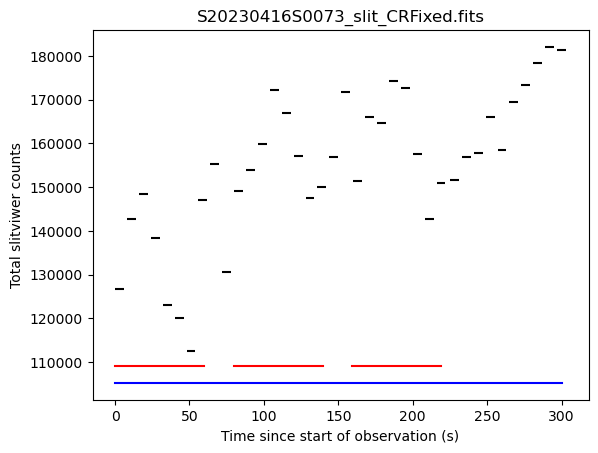

In [54]:
reduce_func(stdslit)

# Select the red standard star data and reduce it. 

In [55]:
stdred = dataselect.select_data(new_all_files5, ['RED'], [])

In [56]:
stdred.sort()
stdred

['S20230416S0073_red001.fits',
 'S20230416S0073_red002.fits',
 'S20230416S0073_red003.fits']

In [57]:
reduce_func(stdred,uparms=('scaleCountsToReference:tolerance',1),recipename='reduceStandard')

All submitted files appear valid:
S20230416S0073_red001.fits ... S20230416S0073_red003.fits, 3 files submitted.
RECIPE: reduceStandard
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
  

    Finding CRs in order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   186 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   Slit parameters for S20230416S0073_red002_arraysTiled.fits:
      processed_slit: S20230416S0073_slit_red002_slit.fits (obtained from ~/.dragons/cal_manager.db)
      processed_slitflat: S20230416S0047_slit_slitflat.fits (obtained from ~/.dragons/cal_manager.db)
      processed_flat: S20230416S0047_red001_flat.fits (obtained from ~/.dragons/cal_manager.db)
   
   IFU status: object and stowed
   
   Estimated seeing in the blue arm: 0.773 (57.0% aperture throughput)
   Estimated seeing in the red arm: 0.709 (62.0% aperture throughput)
   
   Extracting objects [0]; sky subtraction True


    Finding CRs in order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   140 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   Slit parameters for S20230416S0073_red003_arraysTiled.fits:
      processed_slit: S20230416S0073_slit_red003_slit.fits (obtained from ~/.dragons/cal_manager.db)
      processed_slitflat: S20230416S0047_slit_slitflat.fits (obtained from ~/.dragons/cal_manager.db)
      processed_flat: S20230416S0047_red001_flat.fits (obtained from ~/.dragons/cal_manager.db)
   
   IFU status: object and stowed
   
   Estimated seeing in the blue arm: 0.748 (58.9% aperture throughput)
   Estimated seeing in the red arm: 0.687 (63.9% aperture throughput)
   
   Extracting objects [0]; sky subtraction True


    Finding CRs in order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   162 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   .
   PRIMITIVE: attachWavelengthSolution
   -----------------------------------
   Arcs for S20230416S0073_red001_extracted.fits:
      before: S20230416S0049_red001_arc.fits
   Arcs for S20230416S0073_red002_extracted.fits:
      before: S20230416S0049_red001_arc.fits
   Arcs for S20230416S0073_red003_extracted.fits:
      before: S20230416S0049_red001_arc.fits
   .
   PRIMITIVE: scaleCountsToReference
   ---------------------------------
   Objects found in extensions [1]
   Scaling S20230416S0073_red001_wavelengthSolutionAttached.fits by 1.000
   Scaling S20230416S0073_red002_wavelengthSolutionAttached.fits by 0.864
   Scaling S20230416S0073_red003_wavelengthSolutionAttached.fits by 0.852
   .
   PRIMITIVE: stackFrames
   ----------------------
   Combining 3 inputs with mean and none rejection
   Combining extension 1.
   
   Combining extension 2.
   
   .
   PRIMITIVE: calculateSensitivity
   -------------------------------
   S20230416S0073_red001_stack.fits: Using spectropho

# Select the blue standard star data and reduce it. 

In [58]:
stdblue = dataselect.select_data(new_all_files5, ['BLUE'], [])

In [59]:
stdblue.sort()
stdblue

['S20230416S0073_blue001.fits']

In [60]:
reduce_func(stdblue,uparms=('scaleCountsToReference:tolerance',1),recipename='reduceStandard')

All submitted files appear valid:
S20230416S0073_blue001.fits
RECIPE: reduceStandard
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Rebinning bpm_20220601_ghost_blue_11_full_4amp.fits
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the variance
   .
   PRIMITIVE:

    Finding CRs in order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...

   446 CRs found






    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...



   .
   PRIMITIVE: attachWavelengthSolution
   -----------------------------------
   Arcs for S20230416S0073_blue001_extracted.fits:
      before: S20230416S0049_blue001_arc.fits
   .
   PRIMITIVE: scaleCountsToReference
   ---------------------------------
   No scaling will be performed, since at least two AstroData objects are required for scaleCountsToReference
   .
   PRIMITIVE: stackFrames
   ----------------------
   No stacking will be performed, since at least two input AstroData objects are required for stackFrames
   .
   PRIMITIVE: calculateSensitivity
   -------------------------------
   S20230416S0073_blue001_wavelengthSolutionAttached.fits: Using spectrophotometric data file /data0/dragons-3.2.1/anaconda3/envs/dragons/lib/python3.10/site-packages/geminidr/gemini/lookups/spectrophotometric_standards/cd-329927.dat
   S20230416S0073_blue001_wavelengthSolutionAttached.fits is calibrated to air wavelengths
   .
   PRIMITIVE: storeProcessedStandard
   -----------------------

# Clean-up

In [61]:
%%bash

rm *fits

# Science Frames
### Debundle the science frames and reduce them. 

In [62]:
expression = "object=='XX Oph'"
parsed_expr = dataselect.expr_parser(expression)
scibundles = dataselect.select_data(all_files, [], [],parsed_expr)

In [63]:
scibundles

['raw/S20230416S0079.fits']

In [64]:
reduce_func(scibundles)

All submitted files appear valid:
raw/S20230416S0079.fits
RECIPE: processBundle
   PRIMITIVE: splitBundle
   ----------------------
   Unbundling S20230416S0079.fits
   .
	Wrote S20230416S0079_slit.fits in output directory
	Wrote S20230416S0079_blue001.fits in output directory
	Wrote S20230416S0079_red001.fits in output directory
	Wrote S20230416S0079_red002.fits in output directory
	Wrote S20230416S0079_red003.fits in output directory

reduce completed successfully.


# Update the list of files. 

In [65]:
new_all_files6 = update_list()

5 files in the list.


# Select the slit-viewer data and reduce it. 

In [66]:
scislit  = dataselect.select_data(new_all_files6, ['SLIT'], [])

All submitted files appear valid:
S20230416S0079_slit.fits
RECIPE: makeProcessedSlit
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
      PRIMITIVE: addDQ
      ----------------
      No BPMs found for S20230416S0079_slit_prepared.fits and none supplied by the user.
      
      .
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the v

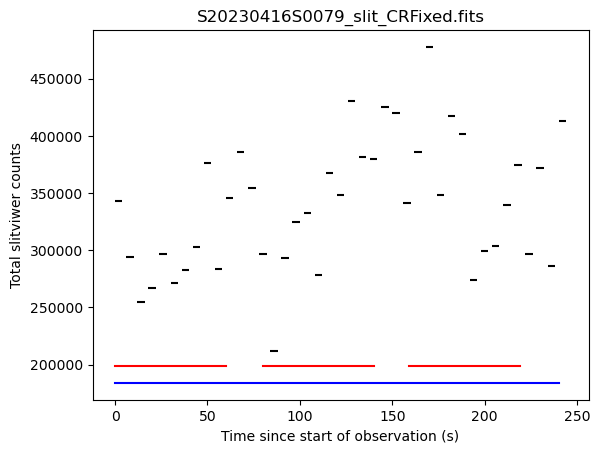

In [67]:
reduce_func(scislit)

# Update the list of files. 

In [68]:
new_all_files7 = update_list()

9 files in the list.


# Select and Reduce the red science frames.

In [69]:
expression = "object=='XX Oph'"
parsed_expr = dataselect.expr_parser(expression)
scired = dataselect.select_data(new_all_files7, ['RED'], [])
np.sort(scired)

array(['S20230416S0079_red001.fits', 'S20230416S0079_red002.fits',
       'S20230416S0079_red003.fits'], dtype='<U26')

In [70]:
reduce_func(scired)

All submitted files appear valid:
S20230416S0079_red001.fits ... S20230416S0079_red003.fits, 3 files submitted.
RECIPE: reduceScience
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_red_11_full_4amp.fits as static BPM
   

    Finding CRs in order 33...34...35...36...37...38...39...40...

   WARNING - There are saturated pixels that have not been flagged as cosmic rays in order 40 pixel 283 (1959-1995)




41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   991 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   Slit parameters for S20230416S0079_red002_arraysTiled.fits:
      processed_slit: S20230416S0079_slit_red002_slit.fits (obtained from ~/.dragons/cal_manager.db)
      processed_slitflat: S20230416S0047_slit_slitflat.fits (obtained from ~/.dragons/cal_manager.db)
      processed_flat: S20230416S0047_red001_flat.fits (obtained from ~/.dragons/cal_manager.db)
   
   IFU status: object and stowed
   
   Estimated seeing in the blue arm: 1.238 (31.0% aperture throughput)
   Estimated seeing in the red arm: 1.141 (35.0% aperture throughput)
   
   Extracting objects [0]; sky subtraction True


    Finding CRs in order 33...34...35...36...37...38...39...40...

   WARNING - There are saturated pixels that have not been flagged as cosmic rays in order 40 pixel 282 (1959-1995)




41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   1136 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   Slit parameters for S20230416S0079_red003_arraysTiled.fits:
      processed_slit: S20230416S0079_slit_red003_slit.fits (obtained from ~/.dragons/cal_manager.db)
      processed_slitflat: S20230416S0047_slit_slitflat.fits (obtained from ~/.dragons/cal_manager.db)
      processed_flat: S20230416S0047_red001_flat.fits (obtained from ~/.dragons/cal_manager.db)
   
   IFU status: object and stowed
   
   Estimated seeing in the blue arm: 1.171 (33.7% aperture throughput)
   Estimated seeing in the red arm: 1.074 (38.2% aperture throughput)
   
   Extracting objects [0]; sky subtraction True


    Finding CRs in order 33...34...35...36...37...38...39...40...

   WARNING - There are saturated pixels that have not been flagged as cosmic rays in order 40 pixel 281 (1959-1995)




41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...

   1287 CRs found






    Extracting order 33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...



   .
   PRIMITIVE: attachWavelengthSolution
   -----------------------------------
   Arcs for S20230416S0079_red001_extracted.fits:
      before: S20230416S0049_red001_arc.fits
   Arcs for S20230416S0079_red002_extracted.fits:
      before: S20230416S0049_red001_arc.fits
   Arcs for S20230416S0079_red003_extracted.fits:
      before: S20230416S0049_red001_arc.fits
   .
   PRIMITIVE: fluxCalibrate
   ------------------------
   S20230416S0079_red001_wavelengthSolutionAttached.fits: using the standard S20230416S0073_red001_standard.fits (obtained from ~/.dragons/cal_manager.db)
   Correcting for difference of 0.124 airmasses
   S20230416S0079_red002_wavelengthSolutionAttached.fits: using the standard S20230416S0073_red001_standard.fits (obtained from ~/.dragons/cal_manager.db)
   Correcting for difference of 0.124 airmasses
   S20230416S0079_red003_wavelengthSolutionAttached.fits: using the standard S20230416S0073_red001_standard.fits (obtained from ~/.dragons/cal_manager.db)
   Correct

# Select and Reduce the blue science frames.

In [71]:
expression = "object=='XX Oph'"
parsed_expr = dataselect.expr_parser(expression)
sciblue = dataselect.select_data(new_all_files7, ['BLUE'], [])

In [72]:
reduce_func(sciblue)

All submitted files appear valid:
S20230416S0079_blue001.fits
RECIPE: reduceScience
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20220601_ghost_blue_11_full_4amp.fits as static BPM
   
   Rebinning bpm_20220601_ghost_blue_11_full_4amp.fits
   .
   PRIMITIVE: addVAR
   -----------------
   Adding the read noise component of the variance
   .
   PRIMITIVE: 

    Finding CRs in order 64...65...66...67...68...69...70...71...

   WARNING - There are saturated pixels that have not been flagged as cosmic rays in order 71 pixel 1183 (631-667)




72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...

   284 CRs found






    Extracting order 64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...



   .
   PRIMITIVE: attachWavelengthSolution
   -----------------------------------
   Arcs for S20230416S0079_blue001_extracted.fits:
      before: S20230416S0049_blue001_arc.fits
   .
   PRIMITIVE: fluxCalibrate
   ------------------------
   S20230416S0079_blue001_wavelengthSolutionAttached.fits: using the standard S20230416S0073_blue001_standard.fits (obtained from ~/.dragons/cal_manager.db)
   Correcting for difference of 0.124 airmasses
   .
   PRIMITIVE: barycentricCorrect
   -----------------------------
   Computing SkyCoord for 265.9854, -6.269094444444445
   Applying radial velocity correction of 24.94914326900919 km/s to S20230416S0079_blue001_fluxCalibrated.fits
   .
   PRIMITIVE: storeProcessedScience
   --------------------------------
   .
   PRIMITIVE: combineOrders
   ------------------------
   Resampling blue arm:  347.4109 to  543.8862nm with 41843 pixels
   Combining extensions numbered 1
   Combining extensions numbered 2
   .
   PRIMITIVE: storeProcessedScience
 

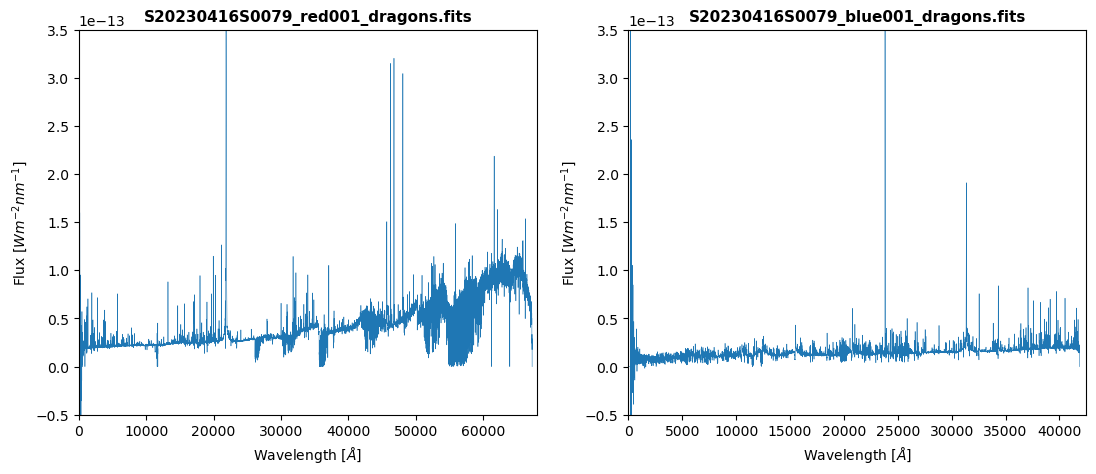

In [73]:
#Display S20230416S0079_red001_dragons.fits and S20230416S0079_blue001_dragons.fits
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,5))

red_file = 'S20230416S0079_red001_dragons.fits'
blue_file = 'S20230416S0079_blue001_dragons.fits'

red_pf = fits.open(red_file)
blue_pf = fits.open(blue_file)

red_data = red_pf[1].data
blue_data = blue_pf[1].data

red_data_array = np.array(red_data)
blue_data_array = np.array(blue_data)

ax1.plot(red_data_array,lw=.4)
ax1.set_xlim(0,68000)
ax1.set_ylim(-0.05*10**(-12),0.35*10**(-12))
ax1.set_xlabel('Wavelength [$\AA$]')
ax1.set_ylabel('Flux [$W  m^{-2}  nm^{-1}$]')
ax1.set_title(red_file,size=11,fontweight='bold')

ax2.plot(blue_data_array,lw=.4)
ax2.set_xlim(0,42500)
ax2.set_ylim(-0.05*10**(-12),0.35*10**(-12))
ax2.set_xlabel('Wavelength [$\AA$]')
ax2.set_ylabel('Flux [$W  m^{-2}  nm^{-1}$]')
ax2.set_title(blue_file,size=11,fontweight='bold')

plt.show()

### If you would like to save the finished spectra as text files instead of fits files, use the write1DSpectra recipe as demonstrated in the following two cells. 

In [74]:
red_to_1d = ['S20230416S0079_red001_dragons.fits']
reduce_func(red_to_1d,recipename='write1DSpectra')

All submitted files appear valid:
S20230416S0079_red001_dragons.fits
WARNING - No recipe can be found in ghost recipe libs.
WARNING - Searching primitives ...
Found 'write1DSpectra' as a primitive.
RECIPE: write1DSpectra
   PRIMITIVE: write1DSpectra
   -------------------------
      PRIMITIVE: write1DSpectra
      -------------------------
      Writing S20230416S0079_red001_dragons_001.dat
      Writing S20230416S0079_red001_dragons_002.dat
      .
   .

reduce completed successfully.


In [75]:
blue_to_1d = ['S20230416S0079_blue001_dragons.fits']
reduce_func(blue_to_1d,recipename='write1DSpectra')

All submitted files appear valid:
S20230416S0079_blue001_dragons.fits
WARNING - No recipe can be found in ghost recipe libs.
WARNING - Searching primitives ...
Found 'write1DSpectra' as a primitive.
RECIPE: write1DSpectra
   PRIMITIVE: write1DSpectra
   -------------------------
      PRIMITIVE: write1DSpectra
      -------------------------
      Writing S20230416S0079_blue001_dragons_001.dat
      Writing S20230416S0079_blue001_dragons_002.dat
      .
   .

reduce completed successfully.


### For more information about the various formats you can write the reduced spectra to, run showpars. The default is ascii.

In [81]:
!showpars S20230416S0079_red001_dragons.fits write1DSpectra

/bin/bash: line 1: showpars: command not found


### If you would to save a png stamp plot of the reduced red and blue spectra, run the following cell. You also have the option to save the image as a different format including svg, eps, and ps by replacing 'png' in the second to last line to your desired format. 

In [83]:
# .- Author: David Herrera - June 2024
# Create a list of all DRAGONS reduced fits files in the current directory
ls_fits = 'ls -1 *{blue,red}00?*_dragons.fits > dragons_fits.list'
os.system(ls_fits)
# Saving the list of DRAGONS reduced fits in a list
fits_list = 'dragons_fits.list'

# Open the list of fits files
with open (fits_list, "r") as files:
    fnames_list = [line.strip() for line in files.readlines()]

# Read each fits file name
for fname in fnames_list:
    # Determine if it is a red or a blue spectrum
    file = str(fname.strip())
    if '_red' in file:
        band = 'red' 
    else:
        band = 'blue'
    # Open and read the data from each FITS file
    ad = astrodata.open(file)
    flux = ad[0].data
    lam = ad[0].wcs(np.arange(flux.size)).astype(np.float32)
     
    # Convert the λ from nm to Å 
    lambda_array = np.array(lam*10)
    flux_array = np.array(flux)
 
    # Define lambda ranges for each panel depending on the band
    if band == 'red':
        lambda_ranges = [(5370, 6330), (6270, 7230), (7170, 8130), (8070, 9030), (8970, 9930)]
    else:
        lambda_ranges = [(3790, 4110), (4090, 4410), (4390, 4710), (4690, 5010), (4990, 5310)]
    # Create a figure and a set of 5 subplots
    fig, axs = plt.subplots(len(lambda_ranges), 1, sharex=False, figsize=(10, 8))
 
    # Plot data in each range
    for i, (lam_min, lam_max) in enumerate(lambda_ranges):
        # Filter data for the current range
        mask = (lambda_array >= lam_min) & (lambda_array <= lam_max)
        lambda_filtered = lambda_array[mask]
        flux_filtered = flux_array[mask]
     
        if len(lambda_filtered) > 0 and len(flux_filtered) > 0:
            # Plot the data
            axs[i].plot(lambda_filtered, flux_filtered, c=band, lw='.6')
            # Calculate the flux median of the range of flux in current range
            flux_median = np.median(flux_filtered)
            # Set the x-limits 
            axs[i].set_xlim(lam_min, lam_max)
            # Set the y-limits for this particular panel
            ylim=(-0.25 * flux_median, 2.5 * flux_median)
            axs[i].set_ylim(ylim)
            axs[i].set
            # Hide tick values in y
            #axs[i].set_yticks([])
            # Handling ticks
            axs[i].minorticks_on()
            if band == 'red':
                axs[i].set_xticks(np.arange(lam_min+30,lam_max+30,step=150))
                axs[i].set_xticks(np.arange(lam_min+80,lam_max,step=50), minor = True)
            axs[i].tick_params(axis = 'y', which='major', labelsize = 8)
        else:
            # Handle the case where no data points are in the range
            axs[i].text(0.5, 0.5, 'No data in this range', transform=axs[i].transAxes,
                     ha='center', va='center', color=band)
 
        # Optionally, set y-label for each panel
        #axs[i].set_yticks()
        # Only y-label on the 3rd panel
        if i == 2: axs[i].set_ylabel('Flux')
 
    # Set x-axis label for the bottom plot
    axs[-1].set_xlabel('λ(Å)')
    # Set title for the whole plot
    fig.suptitle(file)
    # Adjust layout to remove gaps between subplots
    plt.tight_layout()
 
    # Show the plot
    #plt.show()
 
    # Save plot in a file (it can be a png, svg, eps, ps)
    fig.savefig(file.strip('fits') + 'png', dpi='figure', format='png', metadata=None, bbox_inches=None, pad_inches=0.1)
    plt.close()

# Note: This notebook's finished products conform to DRAGONS' fits standards which does not comply with what IRAF expects. If you would like the final reduced spectra to be compatible with IRAF, you can use the makeIRAFCompatible recipe as shown below. (Uncomment before running.)

In [84]:
# reduce_iraf = Reduce()
# red_dragons_files = ['S20230416S0079_red001_dragons.fits']
# reduce_iraf.files.extend(red_dragons_files)
# reduce_iraf.recipename = 'makeIRAFCompatible'
# reduce_iraf.runr()

All submitted files appear valid:
S20230416S0079_red001_dragons.fits
WARNING - No recipe can be found in ghost recipe libs.
WARNING - Searching primitives ...
Found 'makeIRAFCompatible' as a primitive.
RECIPE: makeIRAFCompatible
   PRIMITIVE: makeIRAFCompatible
   -----------------------------
   S20230416S0079_red001_dragons.fits updated and written to disk as S20230416S0079_red001_dragons_irafCompatible.fits
   .

reduce completed successfully.


In [85]:
# reduce_iraf = Reduce()
# blue_dragons_files = ['S20230416S0079_blue001_dragons.fits']
# reduce_iraf.files.extend(red_dragons_files)
# reduce_iraf.recipename = 'makeIRAFCompatible'
# reduce_iraf.runr()

All submitted files appear valid:
S20230416S0079_red001_dragons.fits
WARNING - No recipe can be found in ghost recipe libs.
WARNING - Searching primitives ...
Found 'makeIRAFCompatible' as a primitive.
RECIPE: makeIRAFCompatible
   PRIMITIVE: makeIRAFCompatible
   -----------------------------
   S20230416S0079_red001_dragons.fits updated and written to disk as S20230416S0079_red001_dragons_irafCompatible.fits
   .

reduce completed successfully.


# This notebook has only used DRAGONS' default options. If you would like all the individual exposures to be reduced seperately, you can look into the <a href="https://dragons.readthedocs.io/projects/ghost-drtutorial/en/stable/ex1_ghost_stdonetarget_cmdline.html#alternative-data-products">combineOrders()</a> command. 